In [1]:
import pandas as pd
df_emotion = pd.read_csv('./data/emotion.csv')

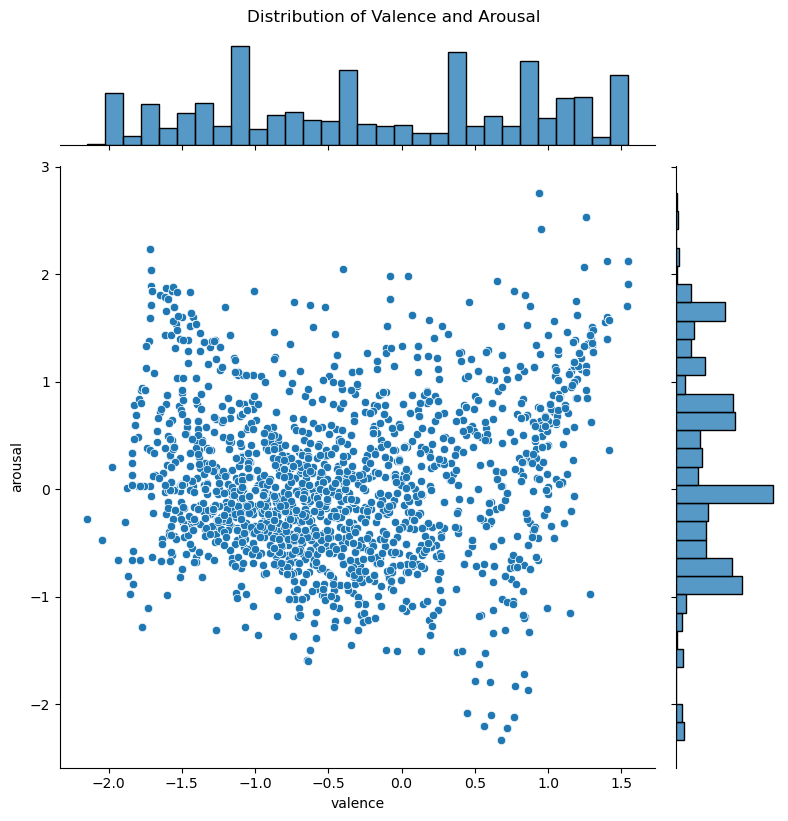

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a jointplot for valence and arousal
sns.jointplot(
    data=df_emotion,
    x="valence",
    y="arousal",
    kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
    height=8
)

# Add a title
plt.suptitle("Distribution of Valence and Arousal", y=1.02)
plt.show()

In [8]:
# Load the dataset
try:
    df_emotion = pd.read_csv('emotion.csv')
    print("emotion.csv loaded successfully.")
    print("First 5 rows of the dataframe:")
    print(df_emotion.head())
    print("\nDataFrame Info (to check column names and types):")
    df_emotion.info()
except FileNotFoundError:
    print("Error: emotion.csv not found. Please ensure it's in the same directory as the notebook, or provide the full path.")
    df_emotion = pd.DataFrame() # Create an empty df to avoid errors in subsequent cells
except Exception as e:
    print(f"An error occurred while loading emotion.csv: {e}")
    df_emotion = pd.DataFrame()

emotion.csv loaded successfully.
First 5 rows of the dataframe:
                    song_id  \
0  5714dec325ac0d8aee380b16   
1  5714dec325ac0d8aee380b17   
2  5714dec325ac0d8aee380b19   
3  5714dec325ac0d8aee381039   
4  5714dec325ac0d8aee38103d   

                                      chord_sequence   valence   arousal  \
0  [{'end': 0.95, 'label': 'Dbmaj', 'start': 0.0}... -1.744233  1.335419   
1  [{'end': 2.35, 'label': 'Dbmaj7', 'start': 0.0... -0.685454 -0.219460   
2  [{'end': 5.95, 'label': 'Cmaj7', 'start': 0.0}... -1.744233  1.335419   
3  [{'end': 6.45, 'label': 'B7', 'start': 0.0}\n ... -0.308878 -0.102691   
4  [{'end': 1.05, 'label': 'Amaj', 'start': 0.0}\...  0.086800 -0.287064   

     bpm  gain  
0  112.0 -10.2  
1  145.0 -14.1  
2   93.0 -16.1  
3  145.0  -7.0  
4  140.0  -7.8  

DataFrame Info (to check column names and types):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7926 entries, 0 to 7925
Data columns (total 6 columns):
 #   Column          Non-Null Cou

In [10]:
import numpy as np
import pandas as pd
import ast # For safely parsing string representations of lists/dictionaries

if 'df_emotion' not in locals() or df_emotion.empty:
    print("Error: df_emotion is not loaded or is empty. Please run the first cell to load the data.")
else:
    print("Processing df_emotion for clustering...")

    # Ensure valence and arousal are numeric and handle potential NaNs by filling with 0 for angle calculation
    df_emotion['valence_cleaned'] = pd.to_numeric(df_emotion['valence'], errors='coerce').fillna(0)
    df_emotion['arousal_cleaned'] = pd.to_numeric(df_emotion['arousal'], errors='coerce').fillna(0)

    # Calculate angle in degrees (0-360)
    angles_rad = np.arctan2(df_emotion['arousal_cleaned'], df_emotion['valence_cleaned'])
    angles_deg = np.degrees(angles_rad)
    df_emotion['angle_deg'] = (angles_deg + 360) % 360

    # Assign to 8 clusters (0-7 for 0-45 deg, 45-90 deg, ..., 315-360 deg)
    df_emotion['emotion_cluster'] = (df_emotion['angle_deg'] // 45).astype(int)
    # Correct cluster 8 (from 360//45) to be 0 if angle is exactly 360
    df_emotion.loc[df_emotion['angle_deg'] == 360, 'emotion_cluster'] = 0

    # Function to extract the first chord label from chord_sequence
    def get_first_chord_label(sequence_str):
        try:
            if pd.isna(sequence_str):
                return None
            sequence_list = ast.literal_eval(str(sequence_str))
            if isinstance(sequence_list, list) and len(sequence_list) > 0:
                first_item = sequence_list[0]
                if isinstance(first_item, dict) and 'label' in first_item:
                    return first_item['label']
            return None
        except (ValueError, SyntaxError, TypeError):
            return None

    df_emotion['first_chord_label'] = df_emotion['chord_sequence'].apply(get_first_chord_label)

    # Ensure 'gain' and 'bpm' are numeric for averaging
    df_emotion['gain'] = pd.to_numeric(df_emotion['gain'], errors='coerce')
    df_emotion['bpm'] = pd.to_numeric(df_emotion['bpm'], errors='coerce')

    print("\nCalculating averages for each emotion cluster:")
    
    # Define a custom mode function using pandas Series.mode()
    def robust_series_mode(series):
        cleaned_series = series.dropna()
        if cleaned_series.empty:
            return None 
        
        # pandas Series.mode() returns a Series of modes (can be multiple)
        modes = cleaned_series.mode() 
        if not modes.empty:
            return modes.iloc[0] # Return the first mode if multiple exist
        return None

    # Group by cluster and calculate aggregates
    cluster_summary = df_emotion.groupby('emotion_cluster').agg(
        average_gain=('gain', 'mean'),
        average_bpm=('bpm', 'mean'),
        most_frequent_first_chord=('first_chord_label', robust_series_mode),
        song_count=('song_id', 'count') 
    ).reset_index()

    # Map cluster numbers to descriptive angle ranges
    # Map cluster numbers to descriptive angle ranges for better readability
    cluster_map = {
        0: "0-45 deg (e.g., Energetic/Joyful)",
        1: "45-90 deg (e.g., Excited/Surprised)",
        2: "90-135 deg (e.g., Agitated/Angry)",
        3: "135-180 deg (e.g., Heavy/Majestic)",
        4: "180-225 deg (e.g., Dark/Depressed)",
        5: "225-270 deg (e.g., Tragic/Yearning)",
        6: "270-315 deg (e.g., Dreamy/Sentimental)",
        7: "315-360 deg (e.g., Calm/Relaxed)"
    }
    cluster_summary['cluster_description'] = cluster_summary['emotion_cluster'].map(cluster_map)
    
    # Reorder columns
    cluster_summary = cluster_summary[['emotion_cluster', 'cluster_description', 'average_gain', 'average_bpm', 'most_frequent_first_chord', 'song_count']]

    print(cluster_summary)

    # Optional: Uncomment to visualize
    # import matplotlib.pyplot as plt
    # import seaborn as sns 
    # plt.figure(figsize=(12, 7))
    # sns.barplot(x='cluster_description', y='song_count', data=cluster_summary, palette='viridis')
    # plt.xlabel("Emotion Cluster (Valence-Arousal Sector)")
    # plt.ylabel("Number of Songs")
    # plt.title("Distribution of Songs Across Emotion Clusters")
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(10, 8))
    # sns.scatterplot(data=df_emotion, x='valence_cleaned', y='arousal_cleaned', hue='emotion_cluster', palette='viridis', s=50, alpha=0.7, legend='full')
    # plt.axhline(0, color='grey', lw=0.5)
    # plt.axvline(0, color='grey', lw=0.5)
    # plt.title('Songs by Emotion Cluster in Valence-Arousal Space')
    # plt.xlabel('Valence (Cleaned)')
    # plt.ylabel('Arousal (Cleaned)')
    # # Ensure legend shows all cluster numbers if they exist
    # handles, labels = plt.gca().get_legend_handles_labels()
    # if handles: # Check if legend items exist
    #     # Create a mapping from string labels (potentially "0.0") to integer cluster numbers
    #     # And then to descriptive labels for the legend
    #     # Assuming labels are cluster numbers as strings: "0", "1", etc.
    #     unique_clusters_in_plot = sorted(df_emotion['emotion_cluster'].unique())
    #     legend_labels = [f"Cluster {i}: {cluster_map.get(i, '')}" for i in unique_clusters_in_plot]
    #     if len(legend_labels) == len(handles): # Make sure mapping matches plotted handles
    #         plt.legend(handles, legend_labels, title='Emotion Cluster')
    #     else: # Fallback if label matching is tricky
    #          plt.legend(title='Emotion Cluster')
    # else:
    #     plt.legend(title='Emotion Cluster') # Default legend if no handles/labels were auto-generated
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.show()

Processing df_emotion for clustering...

Calculating averages for each emotion cluster:
   emotion_cluster                     cluster_description  average_gain  \
0                0       0-45 deg (e.g., Energetic/Joyful)    -10.232245   
1                1     45-90 deg (e.g., Excited/Surprised)     -9.738805   
2                2       90-135 deg (e.g., Agitated/Angry)     -8.964098   
3                3      135-180 deg (e.g., Heavy/Majestic)    -10.625612   
4                4      180-225 deg (e.g., Dark/Depressed)    -11.397655   
5                5     225-270 deg (e.g., Tragic/Yearning)    -11.986392   
6                6  270-315 deg (e.g., Dreamy/Sentimental)    -11.613823   
7                7        315-360 deg (e.g., Calm/Relaxed)    -11.060584   

   average_bpm most_frequent_first_chord  song_count  
0   131.185649                      None        1224  
1   133.021505                      None        1093  
2   136.204641                      None         594  
3   129

In [15]:
import pandas as pd
import numpy as np

if 'df_emotion_filtered' not in locals() or df_emotion_filtered.empty:
    print("Error: 'df_emotion_filtered' is not defined or is empty. \nPlease ensure the previous cell (with clustering) has been run successfully.")
elif 'emotion_cluster' not in df_emotion_filtered.columns:
    print("Error: 'emotion_cluster' column not found in 'df_emotion_filtered'. \nPlease ensure the clustering step in the previous cell was completed.")
else:
    print("Calculating median 'gain' and 'bpm' for each emotion cluster...")

    # Ensure 'gain' and 'bpm' are numeric (they should be from the previous step, but good to be sure)
    # This also handles any new NaNs that might arise if the df was manipulated unexpectedly
    df_emotion_filtered['gain'] = pd.to_numeric(df_emotion_filtered['gain'], errors='coerce')
    df_emotion_filtered['bpm'] = pd.to_numeric(df_emotion_filtered['bpm'], errors='coerce')

    # Group by 'emotion_cluster' and calculate the median for 'gain' and 'bpm'
    median_summary = df_emotion_filtered.groupby('emotion_cluster').agg(
        median_gain=('gain', 'median'),
        median_bpm=('bpm', 'median'),
        song_count=('song_id', 'count') # Also good to see the count of songs per cluster here
    ).reset_index()

    # Map cluster numbers to descriptive angle ranges for better readability
    # This cluster_map should ideally be consistent with the one in the previous cell.
    # If it's not defined here, we'll define a default one.
    if 'cluster_map' not in locals():
        print("Warning: 'cluster_map' not found from previous cell. Using a default map.")
        cluster_map = {
            0: "0-45 deg (e.g., Energetic/Joyful)",
            1: "45-90 deg (e.g., Excited/Surprised)",
            2: "90-135 deg (e.g., Agitated/Tense)",
            3: "135-180 deg (e.g., Anxious/Angry)",
            4: "180-225 deg (e.g., Sad/Depressed)",
            5: "225-270 deg (e.g., Gloomy/Tired)",
            6: "270-315 deg (e.g., Calm/Relaxed)",
            7: "315-360 deg (e.g., Content/Serene)"
        }
    
    median_summary['cluster_description'] = median_summary['emotion_cluster'].map(cluster_map)
    
    # Reorder columns for clarity
    median_summary = median_summary[['emotion_cluster', 'cluster_description', 'median_gain', 'median_bpm', 'song_count']]

    print("\nMedian 'gain' and 'bpm' for each emotion cluster (from filtered data):")
    print(median_summary)

    # Optional: You might want to compare this with the mean values from the previous cell's 'cluster_summary'
    if 'cluster_summary' in locals():
        print("\nFor comparison, here are the MEAN values from the previous summary (if available):")
        # Assuming 'cluster_summary' has 'emotion_cluster', 'average_gain', 'average_bpm'
        # We select relevant columns to avoid clutter if 'cluster_summary' has more.
        if all(col in cluster_summary.columns for col in ['emotion_cluster', 'average_gain', 'average_bpm']):
             print(cluster_summary[['emotion_cluster', 'cluster_description', 'average_gain', 'average_bpm', 'song_count']])
        else:
            print("'cluster_summary' does not have the expected columns for comparison (average_gain, average_bpm).")


Calculating median 'gain' and 'bpm' for each emotion cluster...

Median 'gain' and 'bpm' for each emotion cluster (from filtered data):
   emotion_cluster                     cluster_description  median_gain  \
0                0       0-45 deg (e.g., Energetic/Joyful)         -9.8   
1                1     45-90 deg (e.g., Excited/Surprised)         -9.2   
2                2       90-135 deg (e.g., Agitated/Angry)         -8.2   
3                3      135-180 deg (e.g., Heavy/Majestic)        -10.1   
4                4      180-225 deg (e.g., Dark/Depressed)        -10.9   
5                5     225-270 deg (e.g., Tragic/Yearning)        -11.7   
6                6  270-315 deg (e.g., Dreamy/Sentimental)        -11.1   
7                7        315-360 deg (e.g., Calm/Relaxed)        -10.7   

   median_bpm  song_count  
0       129.0        1216  
1       130.0        1084  
2       134.0         575  
3       128.0        1099  
4       126.0        2048  
5       125.0       

Visualizing distributions of 'gain' and 'bpm' for each emotion cluster...

Generating Histograms for Gain and BPM per Cluster:


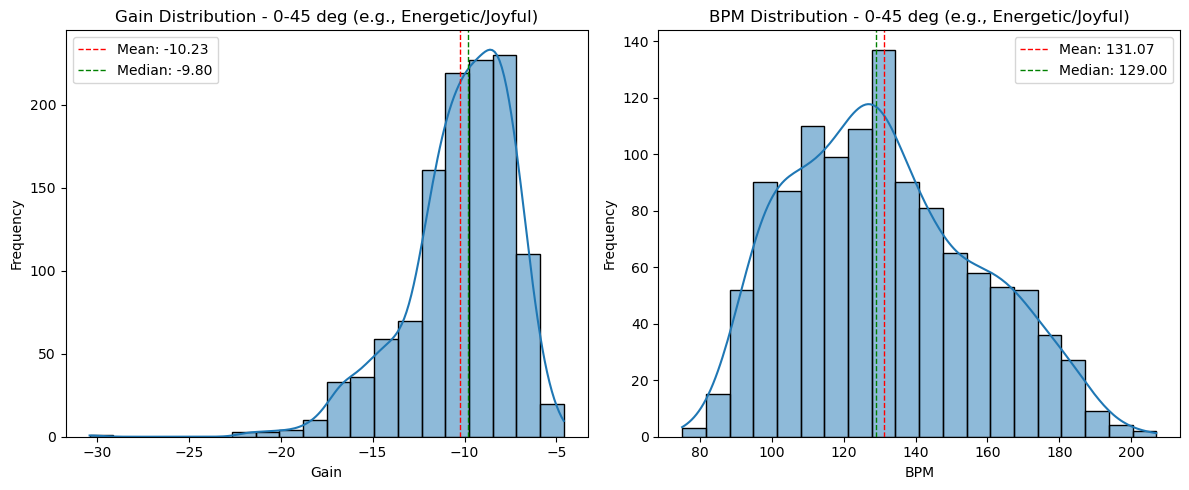

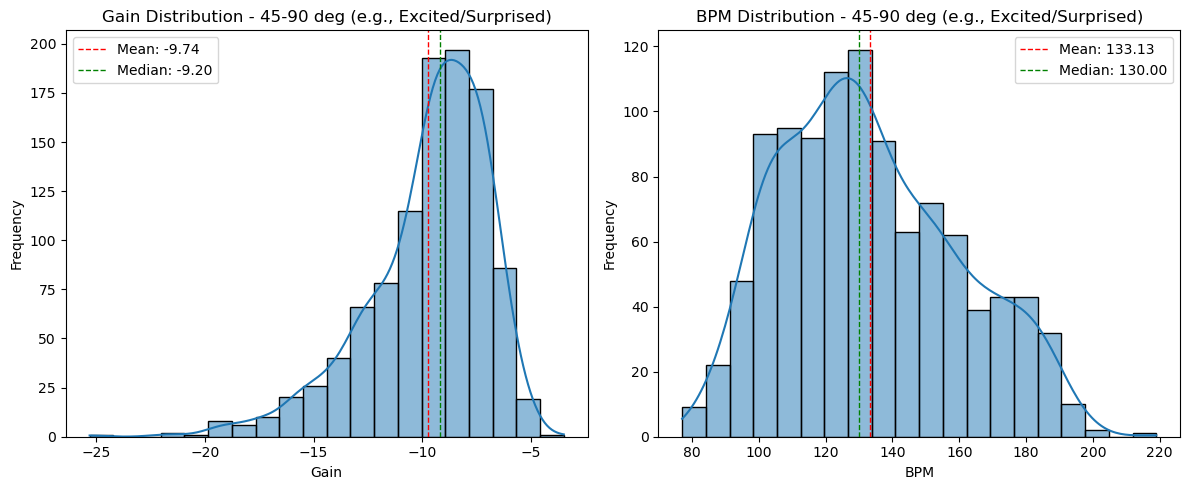

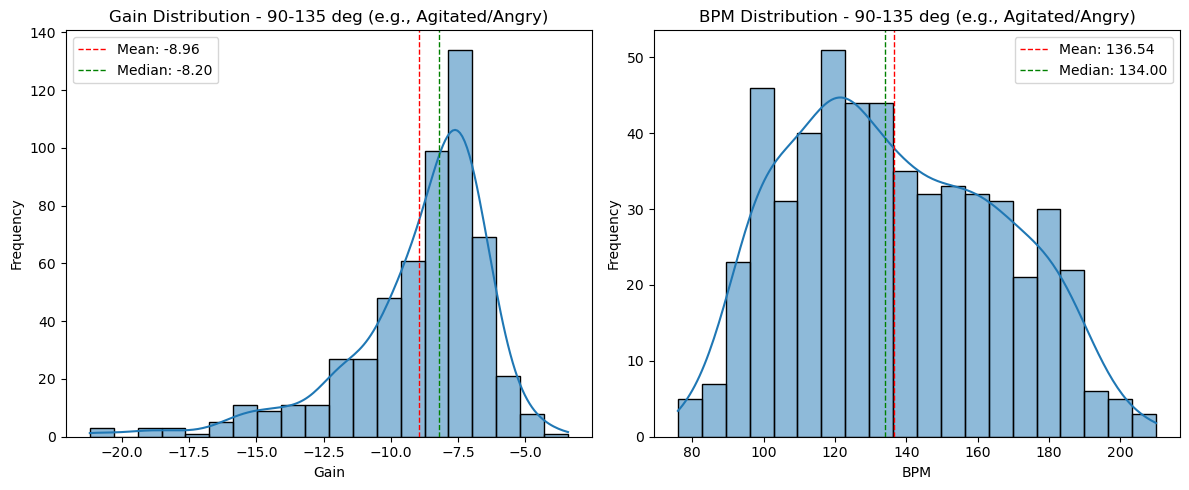

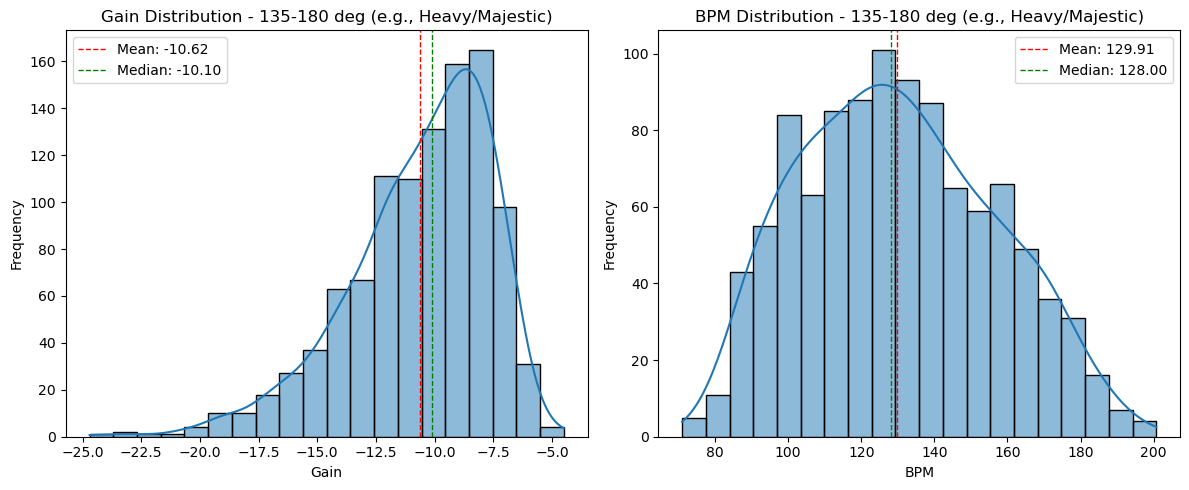

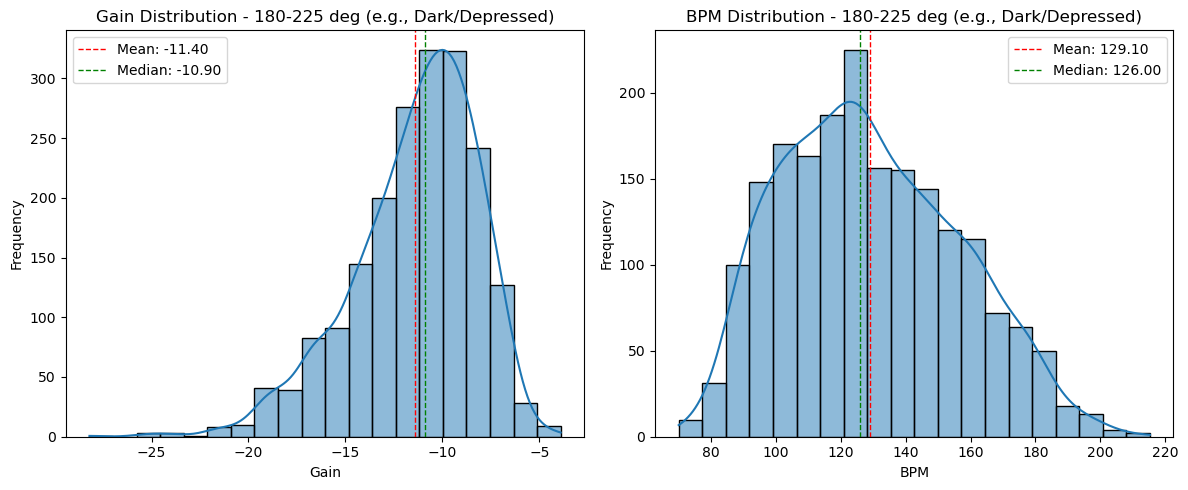

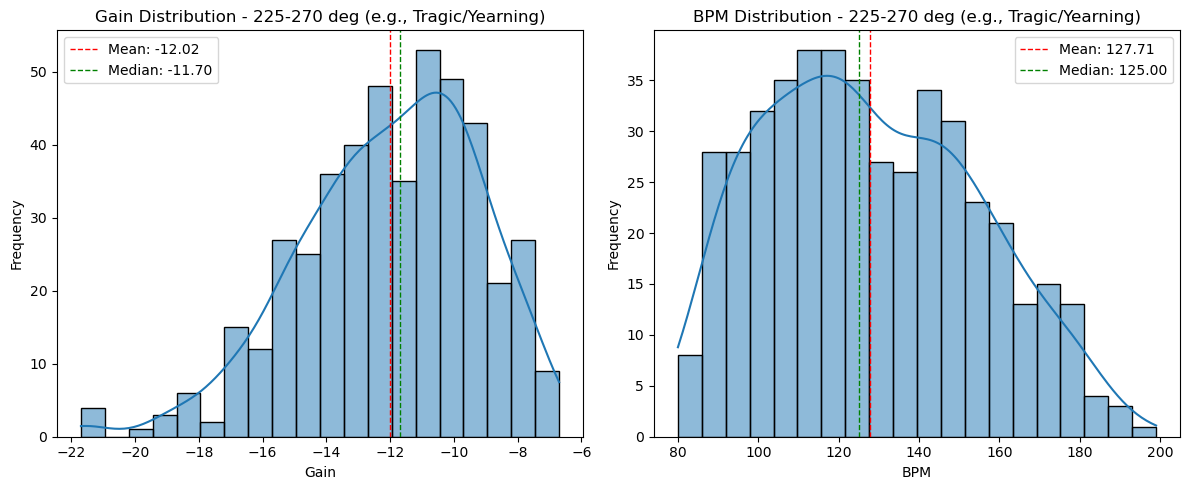

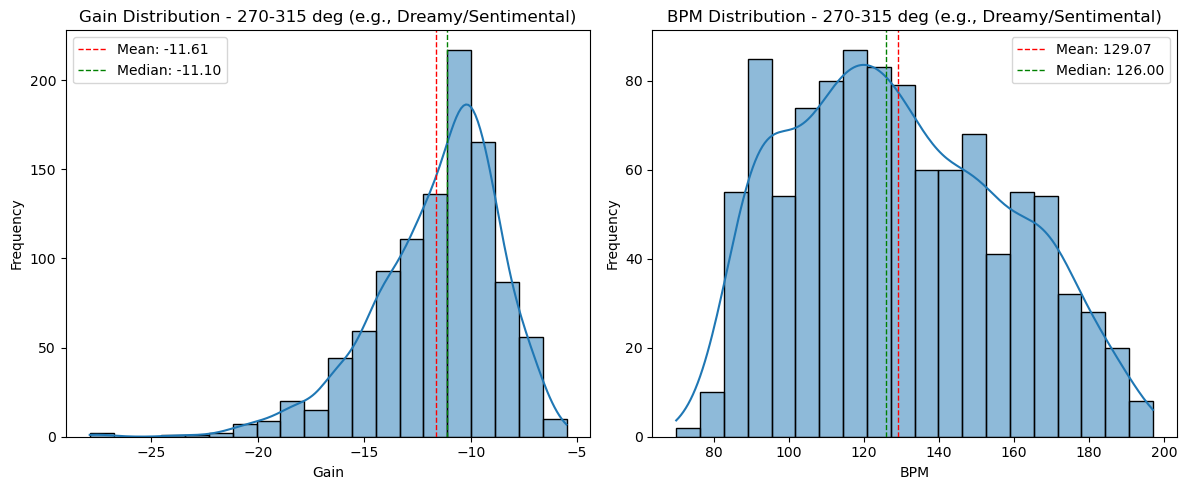

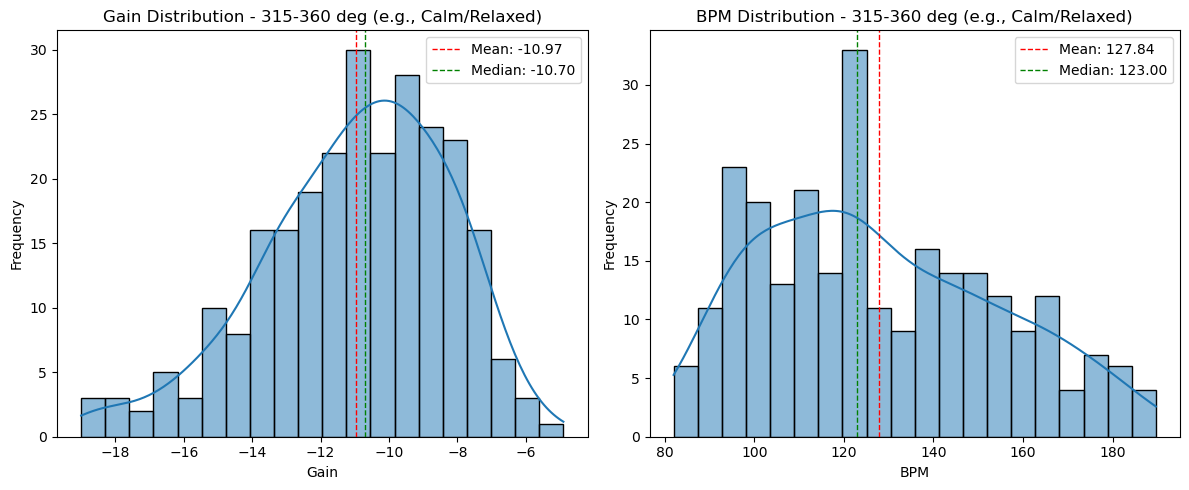


Generating Box Plots for Gain and BPM across all Clusters:


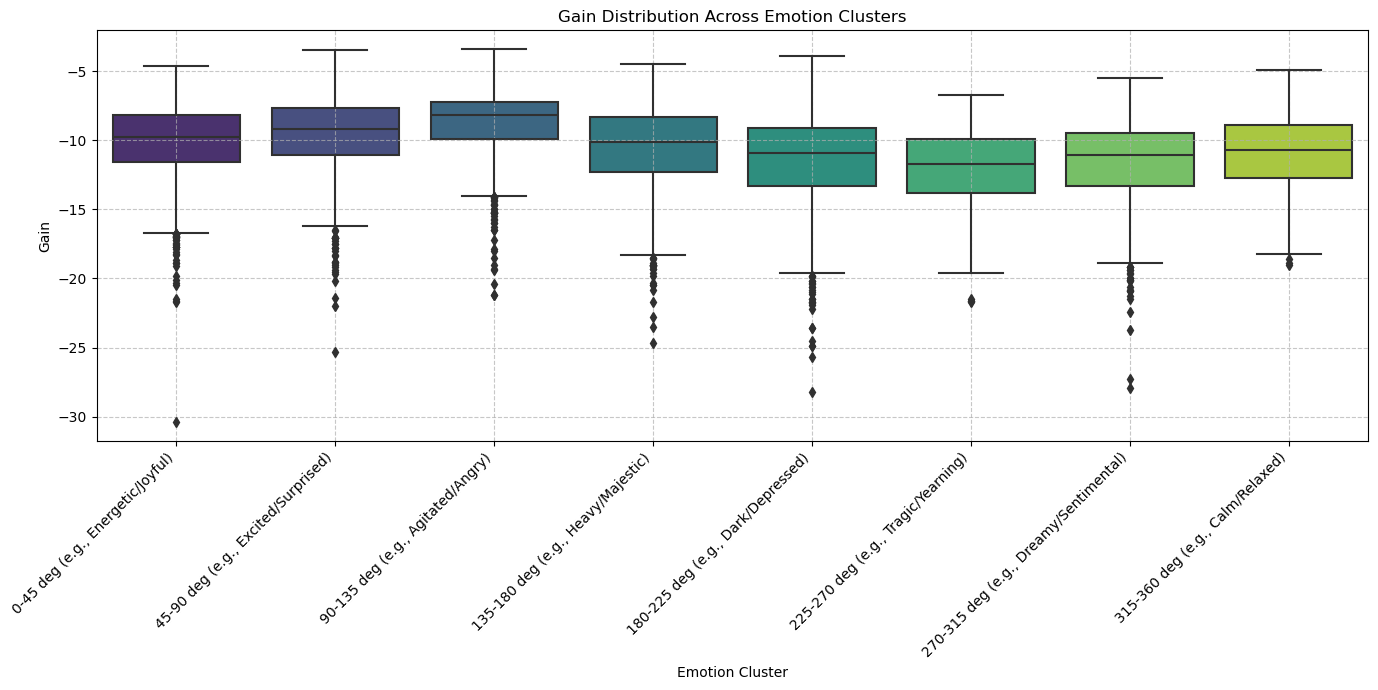

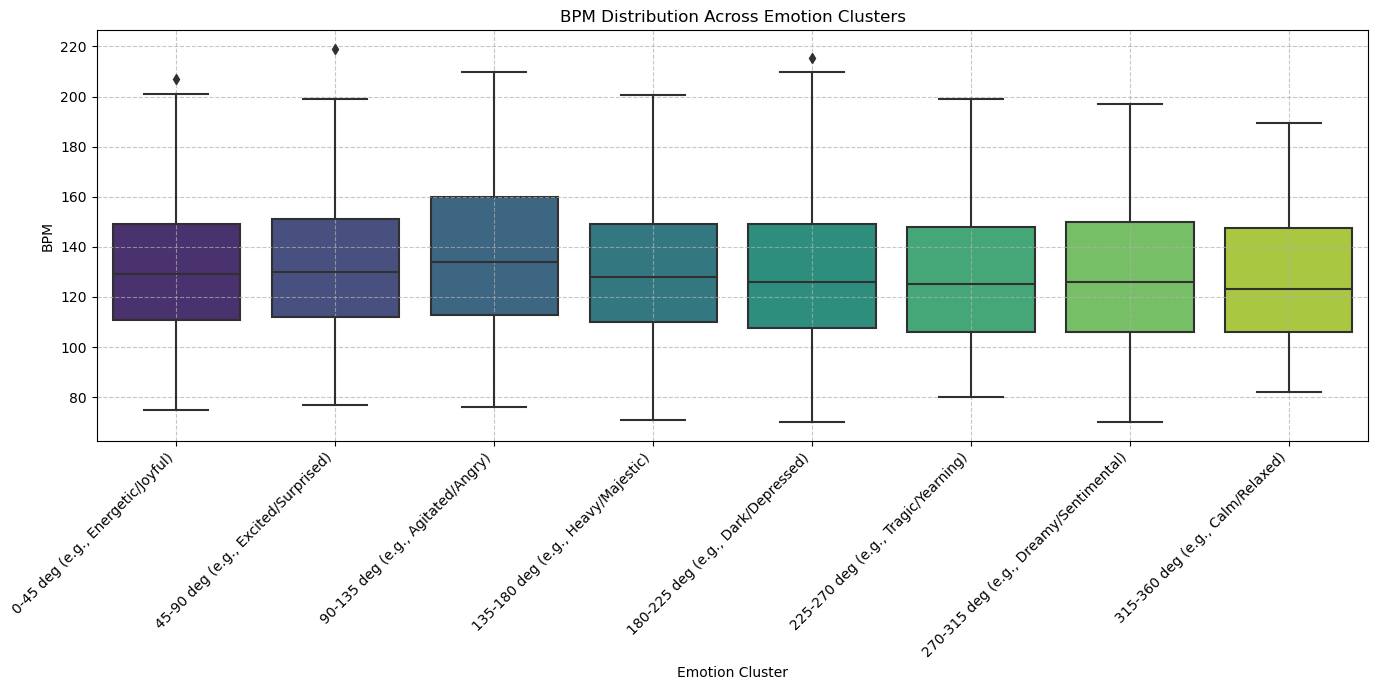


--- Interpretation Guide ---
Look at the histograms for each cluster:
- If a distribution is roughly symmetrical, mean and median will be close. Either can be used.
- If a distribution is skewed (has a long tail to one side), the median is often a better representation of the central tendency.
- The vertical dashed lines show the mean (red) and median (green) on the histograms.
Look at the box plots:
- The line inside the box is the median.
- The box itself represents the Interquartile Range (IQR - middle 50% of the data).
- If the median is not centered in the box, it indicates skewness.
- 'Whiskers' extend to show the range of the data (typically 1.5xIQR), and points beyond are often considered outliers.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_emotion_filtered' not in locals() or df_emotion_filtered.empty:
    print("Error: 'df_emotion_filtered' is not defined or is empty. \nPlease ensure the previous cells have been run successfully.")
elif 'emotion_cluster' not in df_emotion_filtered.columns:
    print("Error: 'emotion_cluster' column not found in 'df_emotion_filtered'. \nPlease ensure the clustering step was completed.")
else:
    print("Visualizing distributions of 'gain' and 'bpm' for each emotion cluster...")

    # Ensure 'gain' and 'bpm' are numeric and handle potential NaNs
    df_emotion_filtered['gain_numeric'] = pd.to_numeric(df_emotion_filtered['gain'], errors='coerce')
    df_emotion_filtered['bpm_numeric'] = pd.to_numeric(df_emotion_filtered['bpm'], errors='coerce')

    # Get the unique clusters sorted
    unique_clusters = sorted(df_emotion_filtered['emotion_cluster'].unique())

    # Retrieve or define cluster_map
    if 'cluster_map' not in locals():
        print("Warning: 'cluster_map' not found. Using a default map for plot titles.")
        cluster_map = {i: f"Cluster {i}" for i in range(8)} # Basic default
        # Attempt to use the more descriptive one if possible
        default_descriptive_map = {
            0: "0-45 deg (e.g., Energetic/Joyful)", 1: "45-90 deg (e.g., Excited/Surprised)",
            2: "90-135 deg (e.g., Agitated/Tense)", 3: "135-180 deg (e.g., Anxious/Angry)",
            4: "180-225 deg (e.g., Sad/Depressed)", 5: "225-270 deg (e.g., Gloomy/Tired)",
            6: "270-315 deg (e.g., Calm/Relaxed)", 7: "315-360 deg (e.g., Content/Serene)"
        }
        # Check if all unique_clusters are in the default_descriptive_map to avoid KeyError
        if all(cluster in default_descriptive_map for cluster in unique_clusters):
             cluster_map = default_descriptive_map


    # --- Histograms for each cluster ---
    print("\nGenerating Histograms for Gain and BPM per Cluster:")
    for cluster_id in unique_clusters:
        cluster_data = df_emotion_filtered[df_emotion_filtered['emotion_cluster'] == cluster_id]
        cluster_desc = cluster_map.get(cluster_id, f"Cluster {cluster_id}")

        plt.figure(figsize=(12, 5))

        # Histogram for Gain
        plt.subplot(1, 2, 1)
        sns.histplot(cluster_data['gain_numeric'].dropna(), kde=True, bins=20)
        mean_gain = cluster_data['gain_numeric'].mean()
        median_gain = cluster_data['gain_numeric'].median()
        plt.axvline(mean_gain, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_gain:.2f}')
        plt.axvline(median_gain, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_gain:.2f}')
        plt.title(f'Gain Distribution - {cluster_desc}')
        plt.xlabel('Gain')
        plt.ylabel('Frequency')
        plt.legend()

        # Histogram for BPM
        plt.subplot(1, 2, 2)
        sns.histplot(cluster_data['bpm_numeric'].dropna(), kde=True, bins=20)
        mean_bpm = cluster_data['bpm_numeric'].mean()
        median_bpm = cluster_data['bpm_numeric'].median()
        plt.axvline(mean_bpm, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bpm:.2f}')
        plt.axvline(median_bpm, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_bpm:.2f}')
        plt.title(f'BPM Distribution - {cluster_desc}')
        plt.xlabel('BPM')
        plt.ylabel('Frequency')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # --- Box Plots for comparing all clusters ---
    print("\nGenerating Box Plots for Gain and BPM across all Clusters:")
    
    # Box Plot for Gain
    plt.figure(figsize=(14, 7))
    # Map numeric clusters to descriptive labels for the x-axis
    # Ensure the order of labels matches the order of plotting for unique_clusters
    xtick_labels_gain = [cluster_map.get(c, str(c)) for c in unique_clusters]
    sns.boxplot(x='emotion_cluster', y='gain_numeric', data=df_emotion_filtered, order=unique_clusters, palette="viridis")
    plt.xticks(ticks=range(len(unique_clusters)), labels=xtick_labels_gain, rotation=45, ha='right')
    plt.title('Gain Distribution Across Emotion Clusters')
    plt.xlabel('Emotion Cluster')
    plt.ylabel('Gain')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Box Plot for BPM
    plt.figure(figsize=(14, 7))
    xtick_labels_bpm = [cluster_map.get(c, str(c)) for c in unique_clusters] # Re-generate for safety or if unique_clusters differs
    sns.boxplot(x='emotion_cluster', y='bpm_numeric', data=df_emotion_filtered, order=unique_clusters, palette="viridis")
    plt.xticks(ticks=range(len(unique_clusters)), labels=xtick_labels_bpm, rotation=45, ha='right')
    plt.title('BPM Distribution Across Emotion Clusters')
    plt.xlabel('Emotion Cluster')
    plt.ylabel('BPM')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n--- Interpretation Guide ---")
    print("Look at the histograms for each cluster:")
    print("- If a distribution is roughly symmetrical, mean and median will be close. Either can be used.")
    print("- If a distribution is skewed (has a long tail to one side), the median is often a better representation of the central tendency.")
    print("- The vertical dashed lines show the mean (red) and median (green) on the histograms.")
    print("Look at the box plots:")
    print("- The line inside the box is the median.")
    print("- The box itself represents the Interquartile Range (IQR - middle 50% of the data).")
    print("- If the median is not centered in the box, it indicates skewness.")
    print("- 'Whiskers' extend to show the range of the data (typically 1.5xIQR), and points beyond are often considered outliers.")
